### Load simulator metadata

In [23]:
from sumo_python.helpers.load_experiment_metadata import load_experiment_config

input_path = "/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/"

config, sim_setup = load_experiment_config(config=input_path + 'config.json',
                        sim_setup=input_path + 'simulation_setups.json',)

In [24]:
import numpy as np
import pandas as pd

from sumo_python.helpers.generate_od_xml import generate_od_xml
from sumo_python.simulator.run_sumo_and_parse_output import run_sumo_and_parse_output
from sumo_python.simulator.ground_truth import run_ground_truth_and_parse
from sumo_python.helpers.nrmse_counts import compute_nrmse_counts

df_gt_data = run_ground_truth_and_parse(config, sim_setup)


od2trips --no-step-log  --spread.uniform --taz-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.taz.xml --tazrelation-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.gt_od.xml -o /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml 
Success.
sumo --output-prefix gt_ --ignore-route-errors=true --net-file=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.net.xml --routes=/Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/gt_od_trips.trips.xml -b 54000 -e 57600 --additional-files /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/quickstart.additional.xml --duration-log.statistics --xml-validation never --vehroutes /Users/rodrse/Documents/DemandCalibration/notebooks

## High-Dimensional sample-efficient Bayesian Optimization 

Source: https://botorch.org/tutorials/saasbo

In [28]:
def objective(x: np.array) -> pd.DataFrame:
    """Compute objective variable. This is the NRMSE loss between ground-truth output
    and the output of the simulation output evaluated at x.

    Args:
        x (np.array): Numpy array of counts to generate TAZ file from.

    Returns:
        pd.Dataframe: Data frame of sampling locations and loss esimate.
    """
    prefix_run = 'iter'    
    generate_od_xml(x, config, sim_setup, prefix_run)
    df_simulated = run_sumo_and_parse_output(config, sim_setup, prefix_run)
    loss_estimate = compute_nrmse_counts(df_gt_data, df_simulated)
    df_output = pd.DataFrame(x.reshape(-1, len(x)),columns = ['x1','x2','x3','x4'])
    df_output['loss_estimate'] = loss_estimate
    
    return df_output

In [29]:
import os
import torch
import pandas as pd

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
bounds = torch.tensor([[400,400,400,400],[1000,1000,1000,1000]], device=device, dtype=dtype) 
bounds


tensor([[ 400.,  400.,  400.,  400.],
        [1000., 1000., 1000., 1000.]], dtype=torch.float64)

### Initial sampling locations

In [30]:
df_0 = pd.read_csv('./data/initial_sampling_locations.csv')

In [31]:
from botorch.utils.transforms import normalize

train_X = torch.from_numpy(df_0[["x1","x2","x3","x4"]].values)
train_X_norm = normalize(train_X,bounds)
train_Y = -1.0 * torch.from_numpy(df_0[["loss_estimate"]].values)


In [32]:
import os

from botorch import fit_fully_bayesian_model_nuts
from botorch.acquisition import qExpectedImprovement
from botorch.models.fully_bayesian import SaasFullyBayesianSingleTaskGP
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf

In [33]:
WARMUP_STEPS = 32
NUM_SAMPLES = 16
THINNING = 16

In [34]:
gp = SaasFullyBayesianSingleTaskGP(
    train_X=train_X, 
    train_Y=train_Y, 
    outcome_transform=Standardize(m=1)
)
fit_fully_bayesian_model_nuts(
    gp,
    warmup_steps=WARMUP_STEPS,
    num_samples=NUM_SAMPLES,
    thinning=THINNING,
    disable_progbar=True,
)
with torch.no_grad():
    posterior = gp.posterior(train_X)

Computing the median lengthscales over the MCMC dimensions makes it clear that the first feature has the smallest lengthscale

In [35]:
print(gp.median_lengthscale.detach())

tensor([0.8675, 0.4921, 1.8251, 7.3524], dtype=torch.float64)


Make predictions with the model¶
In the next cell we show how to make predictions with the SAAS model. You compute the mean and variance for test points just like for any other BoTorch posteriors. Note that the mean and posterior will have an extra batch dimension at -3 that corresponds to the number of MCMC samples (which is 16 in this tutorial).

In [13]:
print(posterior.mean.shape)
print(posterior.variance.shape)b

torch.Size([1, 20, 1])
torch.Size([1, 20, 1])


## BayesOpt loop

In [36]:
from botorch.optim import optimize_acqf

BATCH_SIZE = 1 
NUM_RESTARTS = 10
RAW_SAMPLES = 1024
    
def optimize_acqf_and_get_observation(acq_func,bounds):
    """Optimizes the acquisition function, and returns a new candidate."""
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=torch.tensor([[0.0] * dim, [1.0] * dim], device=device, dtype=dtype),
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )

    # observe new values 
    new_x = candidates.detach()
    
    return unnormalize(new_x, bounds)

### Run loop

In [37]:

NITER = 100
output = [df_0]
best_value = []

for i in range(NITER):
    
    print(f"####### {i+1} ########")
    
    df_ = df_0 if i == 0 else df_i
    
    n_obs = df_.shape[0]
    print(f"##### n={n_obs} #####")
    
    # Training data
    train_X = torch.from_numpy(df_[["x1","x2","x3","x4"]].values)    
    train_X_norm = normalize(train_X,bounds)
    
    train_Y = -torch.from_numpy(df_[["loss_estimate"]].values) # Take negative
    
    # best value so far
    best_y = train_Y.max()
    best_value.append(best_y)
    print(f"##### best_value={best_y} #####")

    # Declare model with newest data
    gp = SaasFullyBayesianSingleTaskGP(
        train_X=train_X_norm,
        train_Y=train_Y,
        outcome_transform=Standardize(m=1),
    )

    # Fit model
    print(f"##### Fitting model #####")
    fit_fully_bayesian_model_nuts(
        gp,
        warmup_steps=WARMUP_STEPS,
        num_samples=NUM_SAMPLES,
        thinning=THINNING,
        disable_progbar=True,
    )

    print(gp.median_lengthscale.detach())    

    # Construct acquistion function 
    EI = qExpectedImprovement(model=gp, best_f=best_y)
    
    # Maximize acquisition function to get next observation
    new_x = optimize_acqf_and_get_observation(acq_func=EI,bounds=bounds)
    
    # Query SUMO on new sampling location
    df_simulation = objective(new_x.cpu().detach().numpy().reshape(-1))
    df_simulation['iter'] = i+1
    
    # Update history of training data
    output.append(df_simulation)
    
    df_i = pd.concat(output)


####### 1 ########
##### n=20 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([6.0185, 1.3071, 1.5377, 1.5067], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~81000.00UPS, vehicles TOT 2800 ACT 486 BUF 0)          
####### 2 ########
##### n=21 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####
tensor([2.4913, 0.9671, 1.9207, 1.4184], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (10ms ~= 100.00*RT, ~71200.00UPS, vehicles TOT 2984 ACT 712 BUF 0)         
####### 3 ########
##### n=22 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####
tensor([1.1809, 1.9462, 3.4537, 1.1194], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/i

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.7565, 0.8418, 2.0000, 2.2314], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~124000.00UPS, vehicles TOT 3290 ACT 868 BUF 0)         
####### 6 ########
##### n=25 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####
tensor([ 5.0130,  1.6280, 10.5467,  0.9637], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~62375.00UPS, vehicles TOT 2693 ACT 499 BUF 0)          
####### 7 ########
##### n=26 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####
tensor([2.1029, 1.7649, 3.3158, 1.1150], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/da

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([2.6848, 1.8533, 2.8638, 1.7904], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~89200.00UPS, vehicles TOT 2200 ACT 446 BUF 0)          
####### 11 ########
##### n=30 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####
tensor([2.3616, 1.4275, 1.8488, 1.4406], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (2ms ~= 500.00*RT, ~147000.00UPS, vehicles TOT 2200 ACT 294 BUF 0)         
####### 12 ########
##### n=31 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([1.5329, 1.6713, 1.4260, 0.9947], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~137000.00UPS, vehicles TOT 2904 ACT 685 BUF 0)         
####### 13 ########
##### n=32 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####
tensor([1.1001, 0.9148, 1.7367, 0.7703], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~145200.00UPS, vehicles TOT 3030 ACT 726 BUF 0)         
####### 14 ########
##### n=33 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####
tensor([1.5653, 0.8410, 0.9999, 0.7662], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.3539, 0.6313, 0.6894, 0.3917], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~115714.29UPS, vehicles TOT 3045 ACT 810 BUF 0)         
####### 19 ########
##### n=38 #####
##### best_value=-0.027004666207663 #####
##### Fitting model #####
tensor([2.1429, 1.4646, 0.9487, 2.0991], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (4ms ~= 250.00*RT, ~118500.00UPS, vehicles TOT 2624 ACT 474 BUF 0)         
####### 20 ########
##### n=39 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([2.3781, 1.0917, 1.4928, 1.1337], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.6220, 1.0175, 0.9483, 0.6211], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~83000.00UPS, vehicles TOT 2652 ACT 581 BUF 0)          
####### 26 ########
##### n=45 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([3.5069, 1.1234, 0.9993, 1.1564], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (3ms ~= 333.33*RT, ~149333.33UPS, vehicles TOT 2525 ACT 448 BUF 0)         
####### 27 ########
##### n=46 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.7813, 0.5929, 0.7144, 0.4403], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (3ms ~= 333.33*RT, ~174333.33UPS, vehicles TOT 2593 ACT 523 BUF 0)         
####### 28 ########
##### n=47 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.5820, 1.2195, 0.9968, 1.3459], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~95400.00UPS, vehicles TOT 2649 ACT 477 BUF 0)          
####### 29 ########
##### n=48 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.8391, 1.2384, 1.1147, 1.2769], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.5932, 0.6550, 0.7143, 0.8443], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~126000.00UPS, vehicles TOT 2694 ACT 630 BUF 0)         
####### 32 ########
##### n=51 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([0.9496, 0.6683, 0.7685, 0.7283], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~111000.00UPS, vehicles TOT 2930 ACT 777 BUF 0)         
####### 33 ########
##### n=52 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.3636, 1.1694, 1.1469, 1.4800], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~96875.00UPS, vehicles TOT 2876 ACT 775 BUF 0)          
####### 34 ########
##### n=53 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.7913, 1.3283, 0.9284, 0.7125], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([1.6535, 0.7434, 0.7145, 0.8898], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~129800.00UPS, vehicles TOT 2785 ACT 649 BUF 0)         
####### 36 ########
##### n=55 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.8745, 2.1548, 1.7870, 1.3957], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~98142.86UPS, vehicles TOT 2777 ACT 687 BUF 330)        
####### 37 ########
##### n=56 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([1.4194, 1.1874, 0.6725, 1.5876], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~125166.67UPS, vehicles TOT 2918 ACT 751 BUF 312)       
####### 38 ########
##### n=57 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.2464, 0.8324, 0.4812, 1.0190], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (6ms ~= 166.67*RT, ~130166.67UPS, vehicles TOT 2858 ACT 781 BUF 188)       
####### 39 ########
##### n=58 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.9751, 1.3714, 1.4746, 1.5055], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.8006, 0.8390, 0.5896, 0.6745], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (7ms ~= 142.86*RT, ~119571.43UPS, vehicles TOT 3066 ACT 837 BUF 0)         
####### 41 ########
##### n=60 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.5980, 1.1162, 1.3052, 0.8042], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~141000.00UPS, vehicles TOT 2740 ACT 705 BUF 0)         
####### 42 ########
##### n=61 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.8552, 1.2505, 0.9889, 0.6988], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.6315, 1.1674, 0.6774, 0.6859], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~87888.89UPS, vehicles TOT 2993 ACT 791 BUF 136)        
####### 46 ########
##### n=65 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.3389, 0.9658, 0.6777, 0.7769], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (1ms ~= 1000.00*RT, ~213000.00UPS, vehicles TOT 1600 ACT 213 BUF 0)        
####### 47 ########
##### n=66 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.6386, 1.0051, 1.0303, 0.6104], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (4ms ~= 250.00*RT, ~155000.00UPS, vehicles TOT 2782 ACT 620 BUF 0)         
####### 48 ########
##### n=67 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.2025, 0.9449, 1.3933, 0.8171], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.3634, 1.0411, 0.7041, 1.0301], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (3ms ~= 333.33*RT, ~186333.33UPS, vehicles TOT 2729 ACT 559 BUF 0)         
####### 53 ########
##### n=72 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.0447, 1.1908, 1.3923, 1.1592], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (13ms ~= 76.92*RT, ~73153.85UPS, vehicles TOT 3158 ACT 951 BUF 93)         
####### 54 ########
##### n=73 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.4002, 1.4345, 1.0014, 1.2177], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (5ms ~= 200.00*RT, ~97400.00UPS, vehicles TOT 2657 ACT 487 BUF 0)          
####### 55 ########
##### n=74 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.0277, 1.2390, 0.8612, 1.2459], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~81444.44UPS, vehicles TOT 2930 ACT 733 BUF 19)         
####### 56 ########
##### n=75 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.7113, 0.6770, 0.5171, 0.5964], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~76777.78UPS, vehicles TOT 2844 ACT 691 BUF 0)          
####### 57 ########
##### n=76 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.7937, 0.8331, 0.9065, 0.7498], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~80222.22UPS, vehicles TOT 2835 ACT 722 BUF 0)          
####### 58 ########
##### n=77 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.3075, 1.2674, 1.3933, 1.3619], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.4291, 0.9367, 1.2847, 1.5395], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~83222.22UPS, vehicles TOT 2591 ACT 749 BUF 209)        
####### 61 ########
##### n=80 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.0582, 1.2752, 1.1352, 1.0584], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (10ms ~= 100.00*RT, ~77500.00UPS, vehicles TOT 2883 ACT 775 BUF 0)         
####### 62 ########
##### n=81 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.8240, 1.5448, 1.0433, 1.0528], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([1.0797, 0.7730, 1.2229, 1.0756], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (11ms ~= 90.91*RT, ~74636.36UPS, vehicles TOT 3121 ACT 821 BUF 279)        
####### 64 ########
##### n=83 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.7752, 0.8462, 0.8415, 0.7852], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (11ms ~= 90.91*RT, ~75727.27UPS, vehicles TOT 3158 ACT 833 BUF 528)        
####### 65 ########
##### n=84 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.9471, 1.0712, 0.9389, 1.2518], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.8884, 0.9558, 0.9901, 0.9178], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~83125.00UPS, vehicles TOT 2802 ACT 665 BUF 0)          
####### 67 ########
##### n=86 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.8521, 0.9473, 0.8300, 0.8256], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~77875.00UPS, vehicles TOT 2863 ACT 623 BUF 0)          
####### 68 ########
##### n=87 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.0529, 1.7911, 1.2422, 1.5753], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([1.1844, 1.4130, 1.2608, 1.7667], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (13ms ~= 76.92*RT, ~70153.85UPS, vehicles TOT 2797 ACT 912 BUF 220)        
####### 70 ########
##### n=89 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.9433, 0.7756, 0.8370, 1.0295], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (16ms ~= 62.50*RT, ~55687.50UPS, vehicles TOT 3415 ACT 891 BUF 585)        
####### 71 ########
##### n=90 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.7071, 1.0521, 0.6543, 0.8284], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (14ms ~= 71.43*RT, ~57000.00UPS, vehicles TOT 2924 ACT 798 BUF 543)        
####### 72 ########
##### n=91 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([1.0078, 1.2106, 1.1482, 1.2570], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickst

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.0769, 1.2116, 1.3175, 1.5362], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~75500.00UPS, vehicles TOT 2859 ACT 906 BUF 124)        
####### 78 ########
##### n=97 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.8339, 1.2497, 0.9494, 1.1101], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (10ms ~= 100.00*RT, ~86700.00UPS, vehicles TOT 2909 ACT 867 BUF 158)       
####### 79 ########
##### n=98 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.7835, 0.8491, 0.8711, 0.6682], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (23ms ~= 43.48*RT, ~35000.00UPS, vehicles TOT 2880 ACT 805 BUF 497)        
####### 80 ########
##### n=99 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.5546, 0.6997, 0.5770, 0.6133], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (11ms ~= 90.91*RT, ~74000.00UPS, vehicles TOT 2971 ACT 814 BUF 386)        
####### 81 ########
##### n=100 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.0881, 1.6651, 1.2445, 1.1898], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (11ms ~= 90.91*RT, ~72909.09UPS, vehicles TOT 2962 ACT 802 BUF 401)        
####### 82 ########
##### n=101 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([0.7262, 1.1263, 0.8104, 0.7896], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (11ms ~= 90.91*RT, ~72727.27UPS, vehicles TOT 2991 ACT 800 BUF 408)        
####### 83 ########
##### n=102 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.5321, 0.8958, 0.7324, 0.7602], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (11ms ~= 90.91*RT, ~64636.36UPS, vehicles TOT 2851 ACT 711 BUF 0)          
####### 84 ########
##### n=103 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.8349, 1.4405, 1.2479, 1.3350], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~72333.33UPS, vehicles TOT 2578 ACT 651 BUF 222)        
####### 85 ########
##### n=104 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.7511, 1.1280, 0.8344, 0.7955], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (10ms ~= 100.00*RT, ~91000.00UPS, vehicles TOT 3066 ACT 910 BUF 334)       
####### 86 ########
##### n=105 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.6611, 1.2174, 1.0878, 0.9656], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quick

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([1.0294, 1.5558, 1.2588, 1.5464], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (16ms ~= 62.50*RT, ~54062.50UPS, vehicles TOT 3012 ACT 865 BUF 314)        
####### 91 ########
##### n=110 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.7522, 1.6826, 0.9889, 1.2711], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~73500.00UPS, vehicles TOT 3008 ACT 882 BUF 218)        
####### 92 ########
##### n=111 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([0.6535, 0.8871, 0.6303, 0.7708], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~71416.67UPS, vehicles TOT 2980 ACT 857 BUF 371)        
####### 93 ########
##### n=112 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.6794, 1.2618, 1.1825, 1.4295], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (13ms ~= 76.92*RT, ~66769.23UPS, vehicles TOT 3073 ACT 868 BUF 291)        
####### 94 ########
##### n=113 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.8716, 1.4369, 1.0387, 1.3726], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quick

/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([1.0309, 1.6378, 1.0403, 1.5156], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~65750.00UPS, vehicles TOT 2867 ACT 789 BUF 299)        
####### 97 ########
##### n=116 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-07 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 9.999999999999999e-06 to the covariance matrix and retrying.
  warnings.warn(
/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 0.009999999999

tensor([0.6538, 1.1522, 0.8912, 0.9504], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (12ms ~= 83.33*RT, ~73166.67UPS, vehicles TOT 3066 ACT 878 BUF 276)        
####### 98 ########
##### n=117 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([0.5829, 1.1818, 0.9039, 1.1432], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (9ms ~= 111.11*RT, ~76222.22UPS, vehicles TOT 2831 ACT 686 BUF 0)          
####### 99 ########
##### n=118 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####


/Users/rodrse/anaconda3/envs/BoTorch/lib/python3.9/site-packages/botorch/models/fully_bayesian.py:124: RuntimeWarning: Received a linear algebra error while sampling with Pyro. Adding a jitter of 1e-08 to the covariance matrix and retrying.
  warnings.warn(


tensor([0.9988, 1.4457, 1.1152, 1.2417], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (8ms ~= 125.00*RT, ~82375.00UPS, vehicles TOT 2783 ACT 659 BUF 0)          
####### 100 ########
##### n=119 #####
##### best_value=-0.0032747967987865477 #####
##### Fitting model #####
tensor([0.7553, 1.0959, 0.8607, 0.9559], dtype=torch.float64)
printing /Users/rodrse/Documents/DemandCalibration/notebooks/od_calibration_sumo_files/quickstart/data/iter_quickstart.current_od.xml
### Runing: iter
Success.
Step #57600.00 (10ms ~= 100.00*RT, ~67000.00UPS, vehicles TOT 2773 ACT 670 BUF 0)         


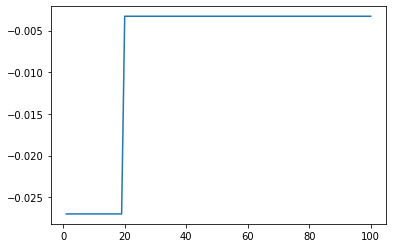

,x1,x2,x3,x4,loss_estimate,iter
0,400.000000,1000.000000,824.587710,400.000000,0.003275,19
0,400.000000,1000.000000,850.902981,680.980665,0.005744,32
0,400.000000,1000.000000,877.902084,505.911014,0.005016,47
0,919.339594,1000.000000,863.569644,575.396481,0.006093,80
0,458.454510,1000.000000,853.657245,540.990521,0.008374,83
0,916.176840,717.208041,882.751798,811.027921,0.003459,90
0,576.402159,777.285060,857.664297,621.633733,0.006705,98


In [41]:
df_plot = df_i.query('iter>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['iter']
y = df_plot['loss_estimate']

plt.plot(x, best_value)
#plt.legend(title='Parameter where:')
plt.show()
df_i.query('loss_estimate<0.010')

In [39]:
df_i.to_csv("./data/saasbo.csv",index = None)